# Setup

In [1]:
import numpy as np
import scipy.io as sio
import math
import matplotlib.pyplot as plt
from matplotlib import image
import glob
from scipy.stats.stats import pearsonr
import mat73
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, mean_squared_error, r2_score

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# which datasets to read and write

do_plastic_flakes = True
do_salient_objects = True
do_indian_pines = True 
do_soil_moisture = True


## Define functions

In [3]:
## dataset loading
# np.random.seed(seed=42)

def load_datasets(Dataset, write=False):
    
    # np.random.seed(seed=42)
    
    if Dataset == 'SM':
        data_path = 'soil_moisture_regression/soilmoisture_dataset.csv'
        # data read and reshape
        df = pd.read_csv(data_path)
        hypbands = []
        for col in df.columns:
            try:
                int(col)
            except Exception:
                continue
            hypbands.append(col)
        data_hsi = df[hypbands]
        gt_hsi = df['soil_moisture']
        data = np.array(data_hsi)
        data = ((data - data.min()) * (1/(data.max() - data.min()) * 255)).astype('uint8')
        gt = np.array(gt_hsi)
    
 
    if Dataset == 'IN':
        data_path = 'land_cover_classification/indian_pines/'
        # data read and reshape
        mat_data = sio.loadmat(data_path + 'Indian_pines_corrected.mat')
        mat_gt = sio.loadmat(data_path + 'Indian_pines_gt.mat')
        data_hsi = mat_data['indian_pines_corrected']
        gt_hsi = mat_gt['indian_pines_gt']
        data = data_hsi.reshape(
            np.prod(data_hsi.shape[:2]), np.prod(data_hsi.shape[2:]))
        data = ((data - data.min()) * (1/(data.max() - data.min()) * 255)).astype('uint8')
        gt = gt_hsi.reshape(np.prod(gt_hsi.shape[:2]), )
    
        # remove NA class (label = 0)
        gt = gt[np.where(gt!=0)[0]]
        data = data[np.where(gt!=0)[0], :]
        
        
    if Dataset == 'SO':
        data_path = 'salient_objects_segmentation/HS-SOD/'
        hsi_paths = glob.glob(data_path + 'hyperspectral/*.mat')
        gt_paths = []
        for i in range(len(hsi_paths)):
            num = hsi_paths[i].split('.')[0].split('/')[-1]
            gt_paths.append(data_path + f'ground_truth/{num}.jpg')
            
        hsi_paths = np.array(hsi_paths)
        gt_paths = np.array(gt_paths)
        gt_write_paths = []
        data_write_paths = []
        
        for path in hsi_paths:
            num = path.split('.')[0].split('/')[-1]
            data_write_tmp = f'../HyperSpectralRL/data/salient_objects/hyperspectral_imagery/{num}.npy'
            data_write_paths.append(data_write_tmp)
            # print(path)

        for path in gt_paths:
            num = path.split('.')[0].split('/')[-1]
            gt_write_tmp = f'../HyperSpectralRL/data/salient_objects/gt_labels/{num}.npy'
            gt_write_paths.append(gt_write_tmp)            
            
        # read samples
        data = []
        data_hsi = []
        gt_hsi = []
        gt = []
        for path in hsi_paths:
            mat_data = mat73.loadmat(path)  
            mat_data = mat_data['hypercube']
            data_hsi.append(mat_data)
            data_tmp = mat_data.reshape(
                np.prod(mat_data.shape[:2]), np.prod(mat_data.shape[2:]))
            data_tmp = ((data_tmp - data_tmp.min()) * (1/(data_tmp.max() - data_tmp.min()) * 255)).astype('uint8')
            data.append(data_tmp)
            
        for path in gt_paths:
            label_mask = image.imread(path)
            gt_hsi.append(label_mask[:,:,0])
            gt_tmp = label_mask[:,:,0].reshape(np.prod(label_mask[:,:,0].shape[:2]), )
            gt_tmp[gt_tmp!=0] = 1
            gt.append(gt_tmp.astype(np.uint8))
        
        if write:
            for itr, img in enumerate(data):
                np.save(data_write_paths[itr], img)
            for itr, img in enumerate(gt):
                np.save(gt_write_paths[itr], img)
              
            
    if Dataset == 'PF':
        data_path = 'plastic_flakes_segmentation/HSOD-ICIP-2022/baselines_cropped/training/'
        hsi_paths = glob.glob(data_path + 'crop/*.npz')
        gt_paths = []
        for i in range(len(hsi_paths)):
            num = hsi_paths[i].split('.')[0].split('/')[-1]
            gt_paths.append(data_path + f'annot/{num}.npy')
            
        hsi_paths = np.array(hsi_paths) 
        gt_paths = np.array(gt_paths) 
        gt_write_paths = []
        data_write_paths = []
        
        for path in hsi_paths:
            num = path.split('.')[0].split('/')[-1]
            data_write_tmp = f'../HyperSpectralRL/data/plastic_flakes/hyperspectral_imagery/{num}.npy'
            data_write_paths.append(data_write_tmp)
            # print(path) 
        
        for path in gt_paths:
            num = path.split('.')[0].split('/')[-1]
            gt_write_tmp = f'../HyperSpectralRL/data/plastic_flakes/gt_labels/{num}.npy'
            gt_write_paths.append(gt_write_tmp)            
            
        # read samples
        data = []
        data_hsi = []
        gt_hsi = []
        gt = []
        for path in hsi_paths:
            raw_data = np.load(path) 
            arr = raw_data['raw']
            data_hsi.append(arr)
            new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
            data_tmp = new_arr.reshape(
                np.prod(new_arr.shape[:2]), np.prod(new_arr.shape[2:]))
            data.append(data_tmp)
            
        for path in gt_paths:
            label_mask = np.load(path)
            gt_hsi.append(label_mask)
            gt_tmp = label_mask.reshape(np.prod(label_mask.shape[:2]), )
            gt.append(gt_tmp.astype(np.uint8))
        
        if write:
            for itr, img in enumerate(data):
                np.save(data_write_paths[itr], img)
            for itr, img in enumerate(gt):
                np.save(gt_write_paths[itr], img)
            
        
    return data_hsi, gt_hsi, data, gt


In [4]:
def normalize(data, mean, std): 
    return (data - mean) / std


def baseline_supervised_pass(data, labels, Dataset, random_subset=False, num_random_bands=15):
    
    # train val split
    # data = np.load(data_fpath)
    if random_subset:
        indices = np.random.randint(0, data.shape[1], num_random_bands)
        data = data[:,indices]
        
    # print(data.shape)

    # labels = np.load(labels_fpath)
    
    if Dataset == 'SM':

        train_images, val_images, train_labels, val_labels = train_test_split(data, 
                                                                labels, 
                                                                test_size=0.3, 
                                                                random_state=42)
        
        clf = LinearRegression()
        
        train_mu = np.mean(train_images)
        train_std = np.std(train_images)
        
        train_images = normalize(train_images, train_mu, train_std)
        val_images = normalize(val_images, train_mu, train_std)
        
        clf.fit(train_images, train_labels)
        val_predictions = clf.predict(val_images)
        mse = mean_squared_error(val_labels, val_predictions)
        r2 = r2_score(val_labels, val_predictions)  
        
        return mse, r2        
        
    else:
        train_images, val_images, train_labels, val_labels = train_test_split(data, 
                                                                labels, 
                                                                test_size=0.3, 
                                                                random_state=42,
                                                                stratify = labels)   
    
        clf = LogisticRegression(multi_class='multinomial')
        
        train_mu = np.mean(train_images)
        train_std = np.std(train_images)
        
        train_images = normalize(train_images, train_mu, train_std)
        val_images = normalize(val_images, train_mu, train_std)    

        clf.fit(train_images, train_labels)
        val_predictions = clf.predict(val_images)
        acc = accuracy_score(val_labels, val_predictions)        
        bac = balanced_accuracy_score(val_labels, val_predictions)
        f1 = f1_score(val_labels, val_predictions, average='macro')   
        
        return acc, bac, f1
    

## Plastic flakes dataset


Dataset info...
The shape of one original image: (876, 128, 224)
The shape of one original label: (876, 128)
The shape of one flattened image: (112128, 224)
The shape of one flattened label: (112128,)




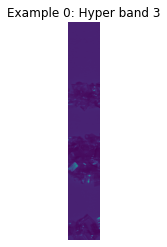

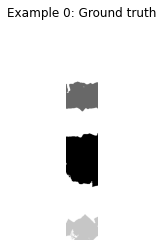

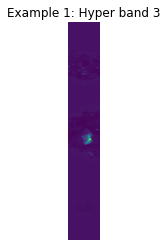

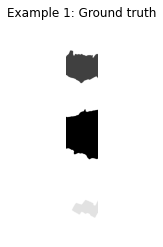

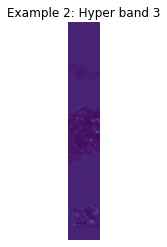

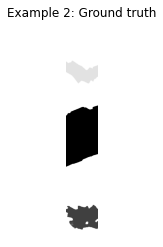

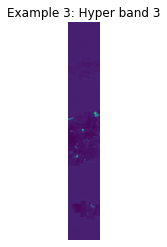

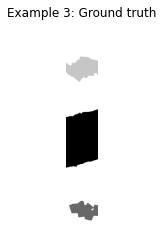

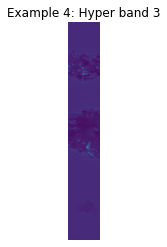

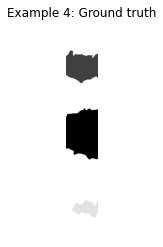

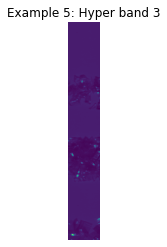

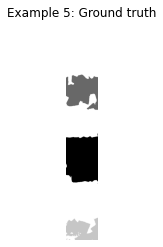

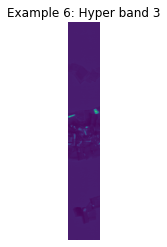

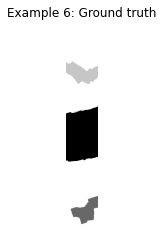

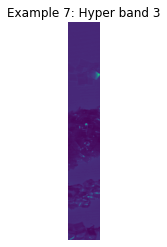

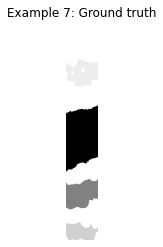

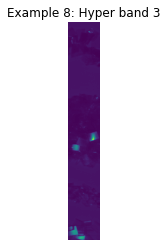

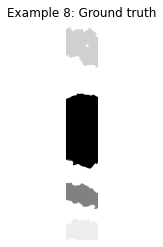

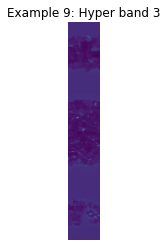

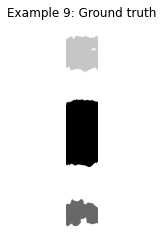

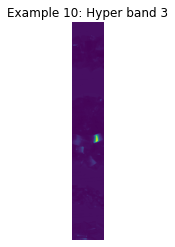

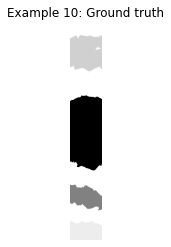

<Figure size 432x288 with 0 Axes>

In [5]:
if do_plastic_flakes:
    data_hsi, gt_hsi, data, gt = load_datasets(
        'PF', write=False)
    
    print('\nDataset info...')
    print('The shape of one original image:', data_hsi[0].shape)
    print('The shape of one original label:', gt_hsi[0].shape)
    print('The shape of one flattened image:', data[0].shape)
    print('The shape of one flattened label:', gt[0].shape)
    print('\n')
    for i in range(len(data_hsi)):
        
        # plot a sample band
        plt.imshow(data_hsi[i][:,:,3])
        plt.title(f'Example {i}: Hyper band 3')
        plt.axis("off")
        plt.show()
        plt.figure()
        # plot the labels
        plt.imshow(gt_hsi[i], cmap = 'Greys')
        plt.title(f'Example {i}: Ground truth')
        plt.axis("off")
        plt.show()
        plt.figure()
        print('\n')
        

In [6]:
if do_plastic_flakes:
    
    print(data_hsi[2][0:3, 0:3, 0:3])

[[[843.37726 843.37726 841.0628 ]
  [821.5063  821.5063  814.20264]
  [812.72766 812.72766 805.37396]]

 [[830.44995 830.44995 828.70605]
  [821.5063  821.5063  826.656  ]
  [799.781   799.781   793.01404]]

 [[830.44995 830.44995 828.70605]
  [860.607   860.607   851.5628 ]
  [864.51434 864.51434 854.8137 ]]]


In [7]:
# baseline models

if do_plastic_flakes:

    # model with all bands included
    
    accs, bacs, f1s = [], [], []
    for i in range(0, len(data_hsi)):
        data = data_hsi[i].reshape(
                np.prod(data_hsi[i].shape[:2]), np.prod(data_hsi[i].shape[2:]))
        labels = gt_hsi[i].reshape(np.prod(data_hsi[i].shape[:2]))
    
        acc, bac, f1 = baseline_supervised_pass(data, labels, 'PF')
        accs.append(acc)
        bacs.append(bac)
        f1s.append(f1)
    
    print(f'Baseline model performance on raw data (floats) with all bands...')
    print(f'Validation Accuracy: {np.mean(accs)}')
    print(f'Validation Balanced Accuracy: {np.mean(bacs)}')
    print(f'Validation Macro Averaged F1 Score: {np.mean(f1s)}')
    
    # model with random bands
    
    accs, bacs, f1s = [], [], []
    for i in range(0, len(data_hsi)):
        data = data_hsi[i].reshape(
                np.prod(data_hsi[i].shape[:2]), np.prod(data_hsi[i].shape[2:]))
        labels = gt_hsi[i].reshape(np.prod(data_hsi[i].shape[:2]))
    
        acc, bac, f1 = baseline_supervised_pass(data, labels, 'PF', True, 10)
        accs.append(acc)
        bacs.append(bac)
        f1s.append(f1)
    
    print(f'\nBaseline model performance on raw data (floats) with {10} band random subset...')
    print(f'Validation Accuracy: {np.mean(accs)}')
    print(f'Validation Balanced Accuracy: {np.mean(bacs)}')
    print(f'Validation Macro Averaged F1 Score: {np.mean(f1s)}')

Baseline model performance on raw data (floats) with all bands...
Validation Accuracy: 0.978504387493953
Validation Balanced Accuracy: 0.9662620911797156
Validation Macro Averaged F1 Score: 0.9644995559791972

Baseline model performance on raw data (floats) with 10 band random subset...
Validation Accuracy: 0.9569790475881619
Validation Balanced Accuracy: 0.9275680524475834
Validation Macro Averaged F1 Score: 0.9290204099097149


## Salient objects dataset


Dataset info...
The shape of one original image: (768, 1024, 81)
The shape of one original label: (768, 1024)
The shape of one flattened image: (786432, 81)
The shape of one flattened label: (786432,)
The number of different classes: 2


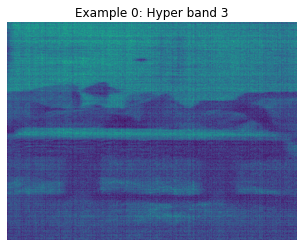

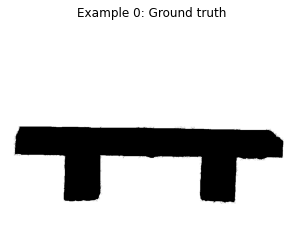

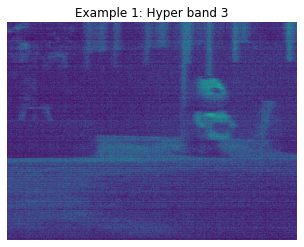

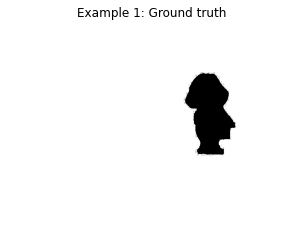

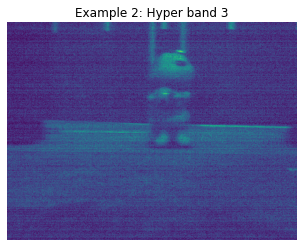

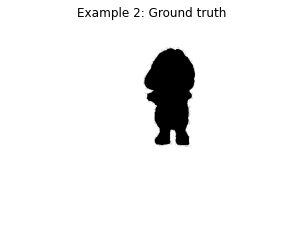

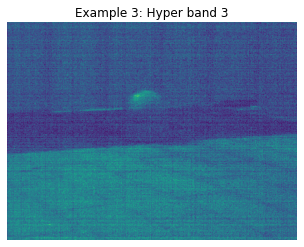

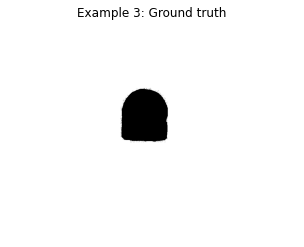

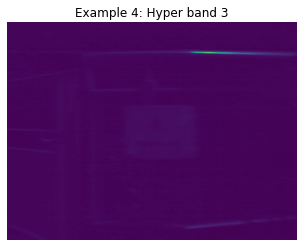

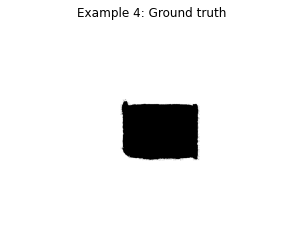

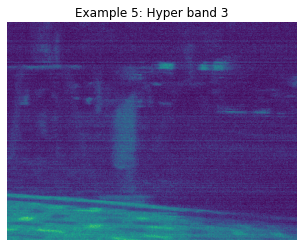

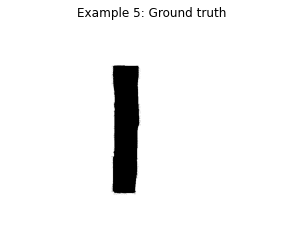

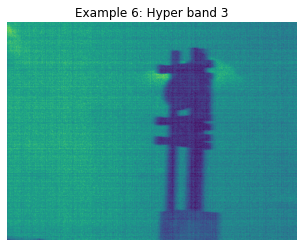

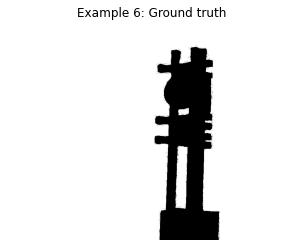

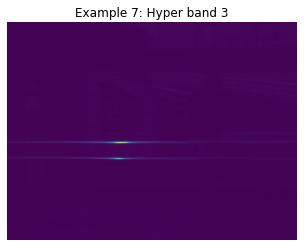

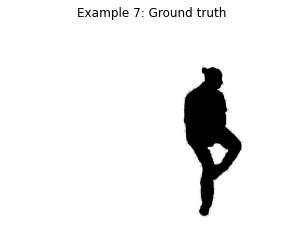

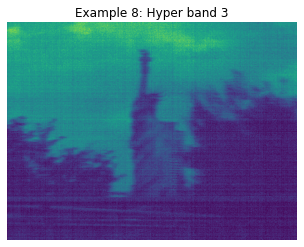

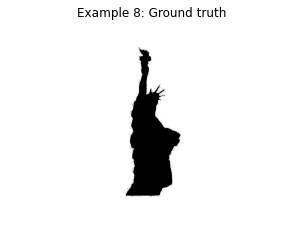

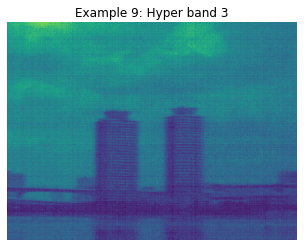

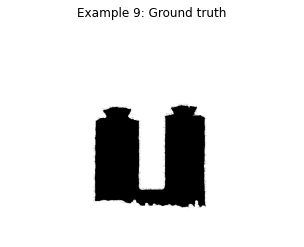

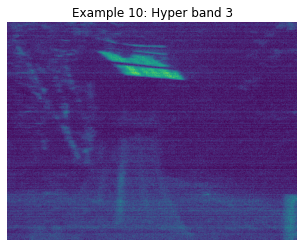

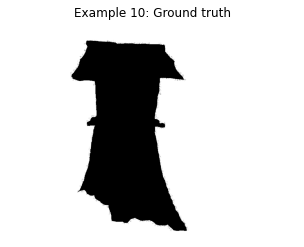

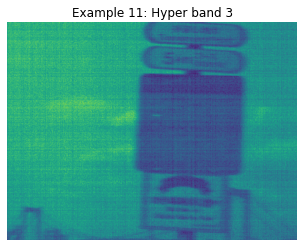

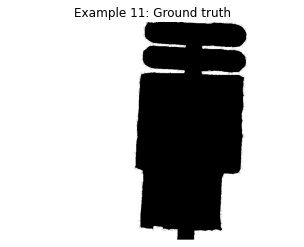

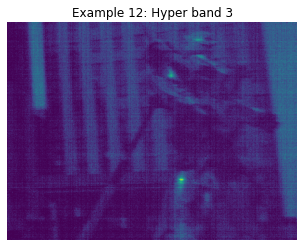

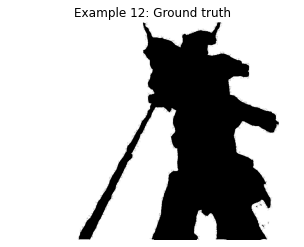

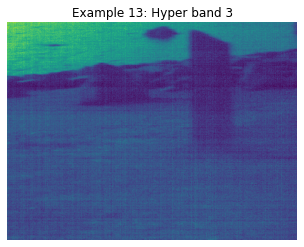

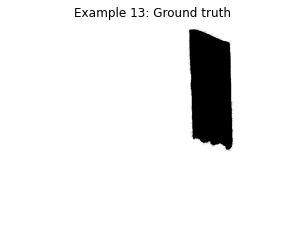

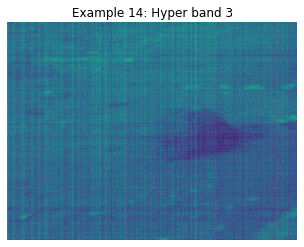

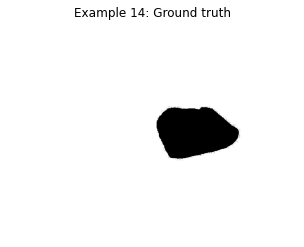

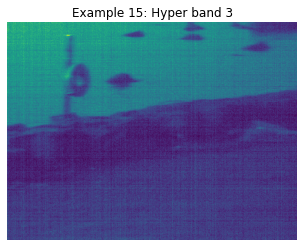

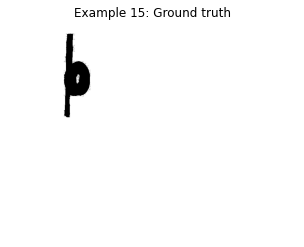

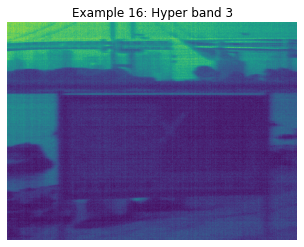

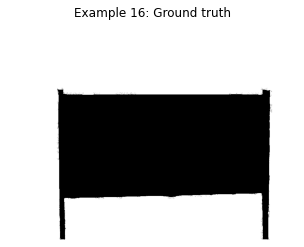

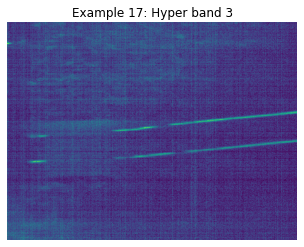

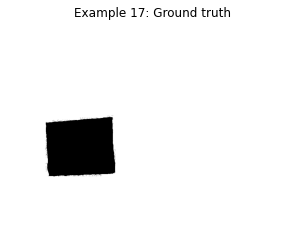

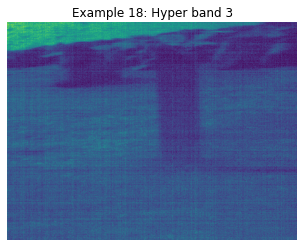

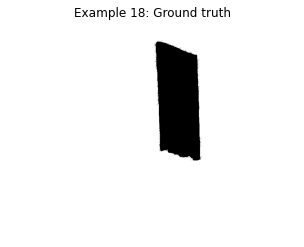

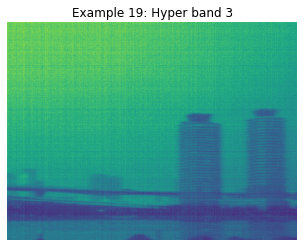

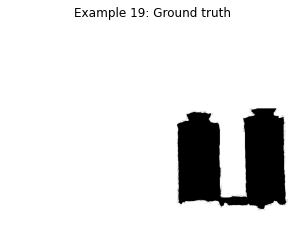

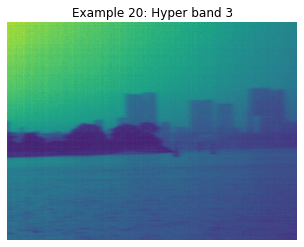

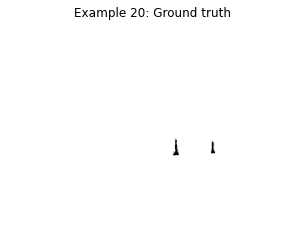

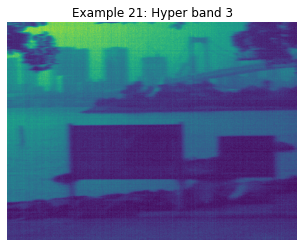

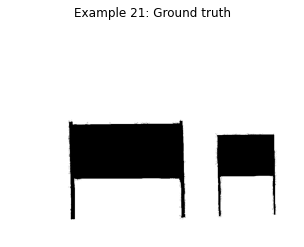

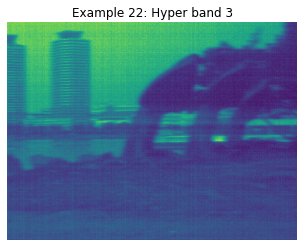

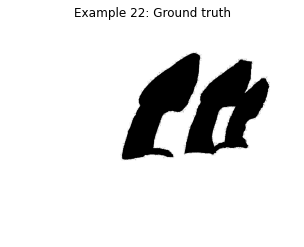

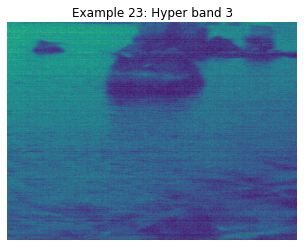

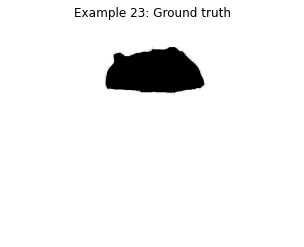

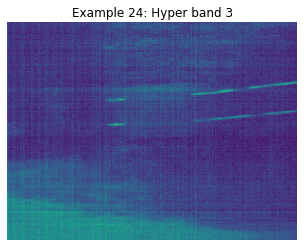

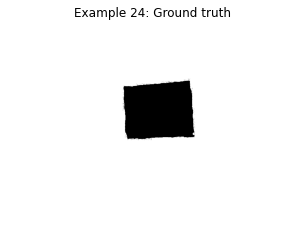

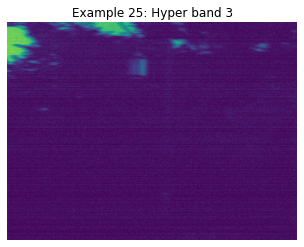

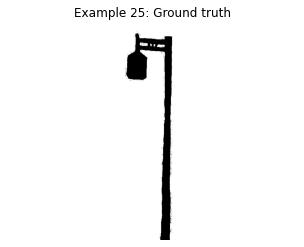

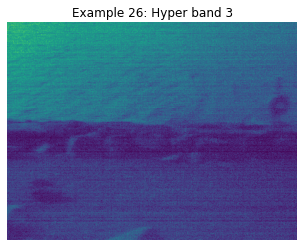

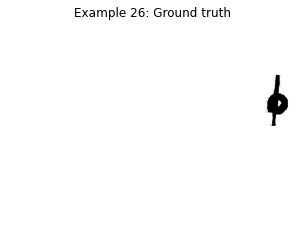

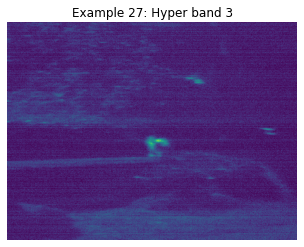

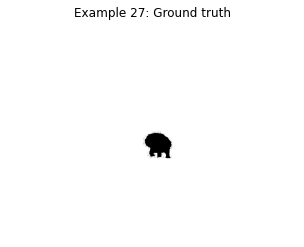

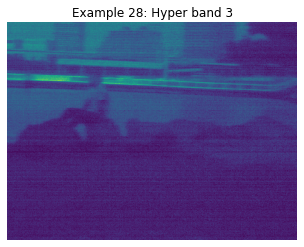

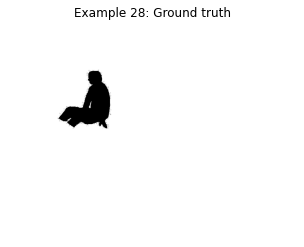

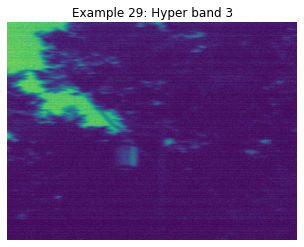

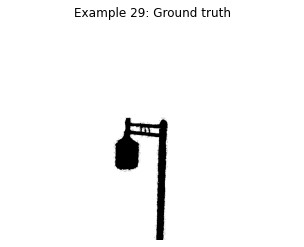

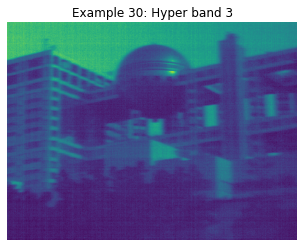

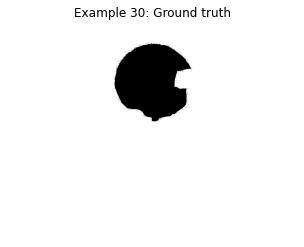

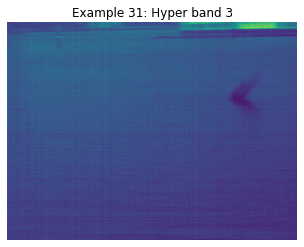

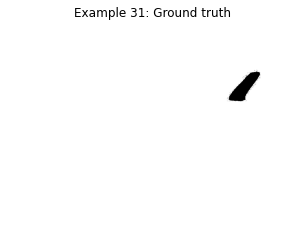

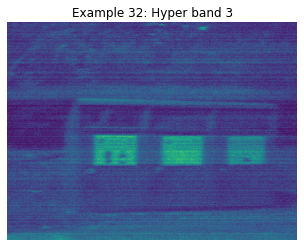

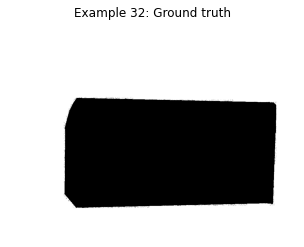

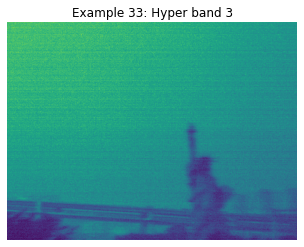

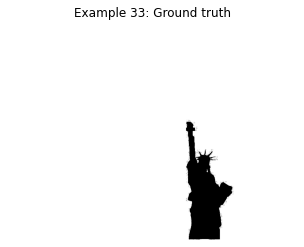

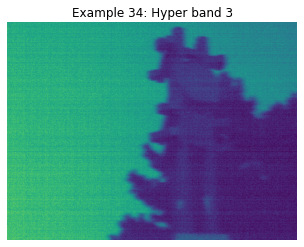

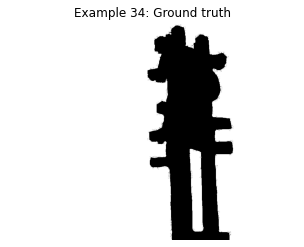

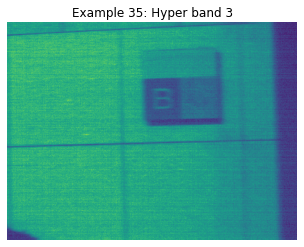

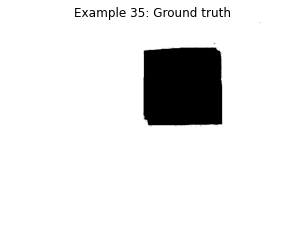

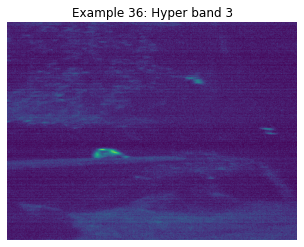

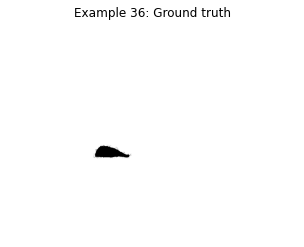

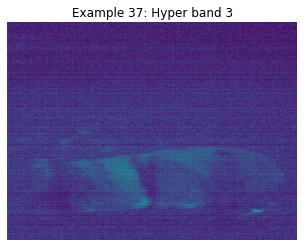

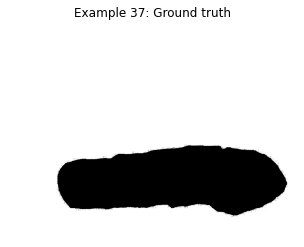

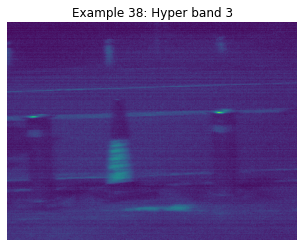

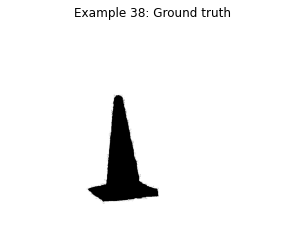

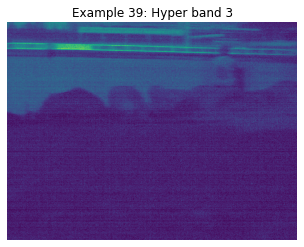

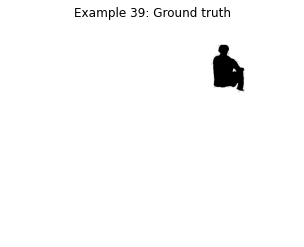

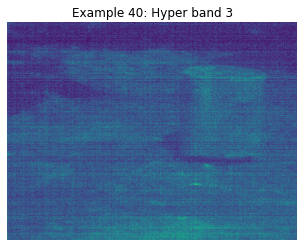

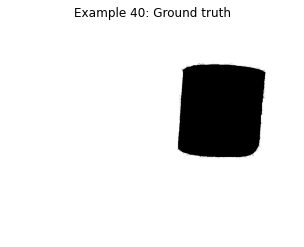

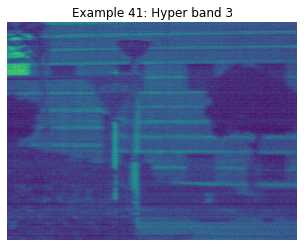

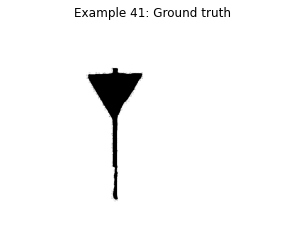

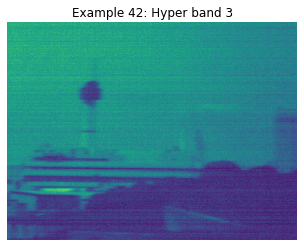

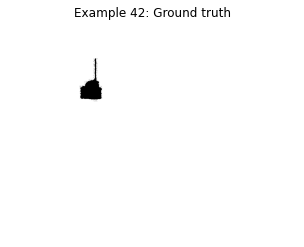

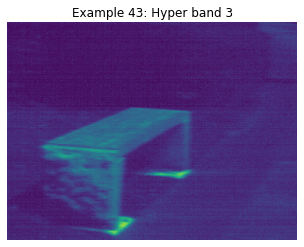

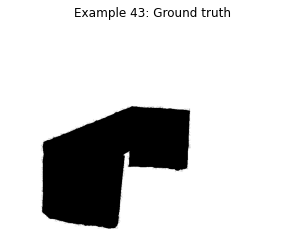

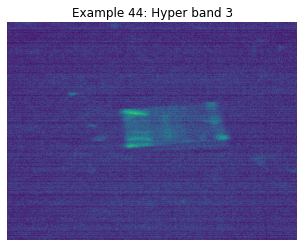

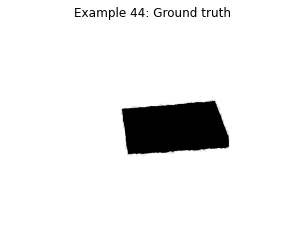

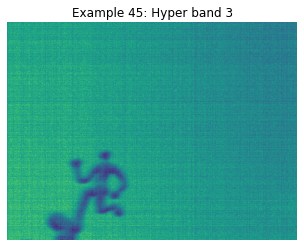

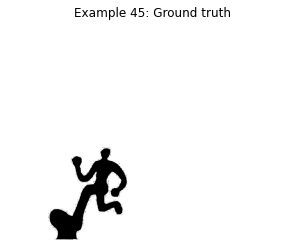

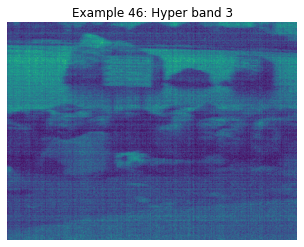

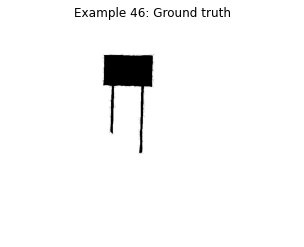

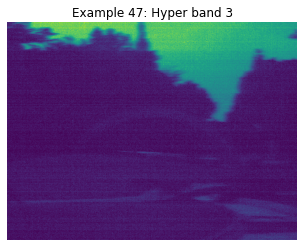

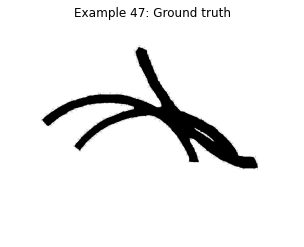

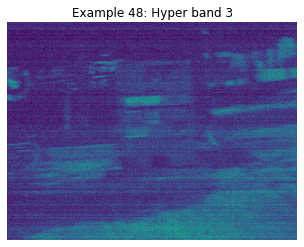

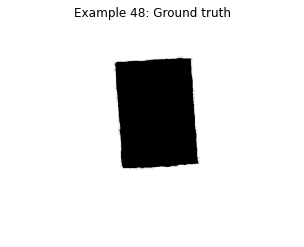

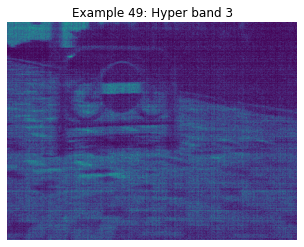

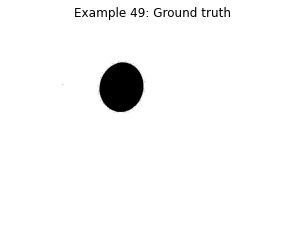

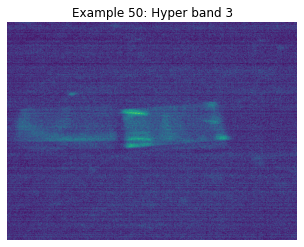

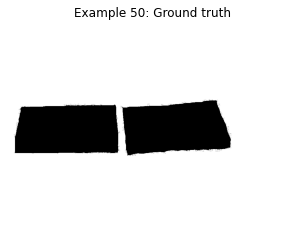

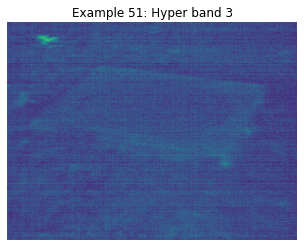

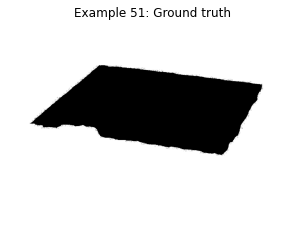

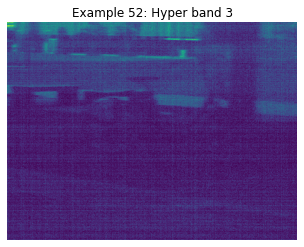

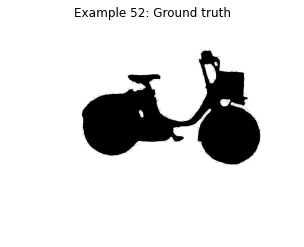

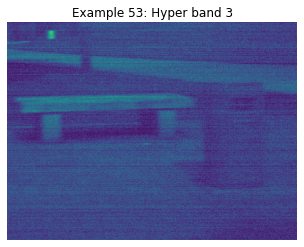

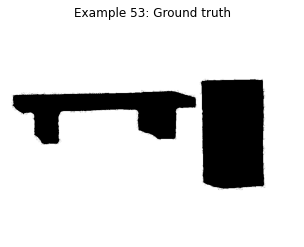

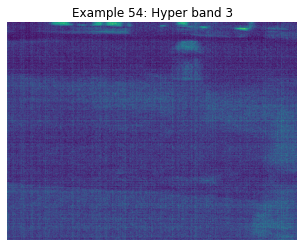

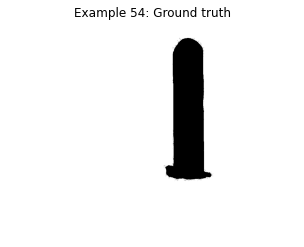

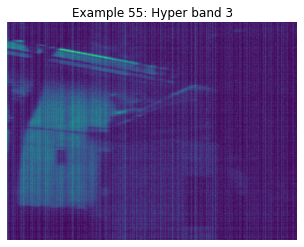

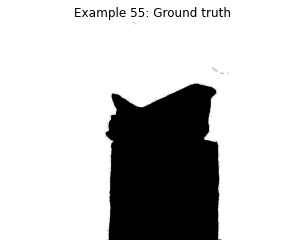

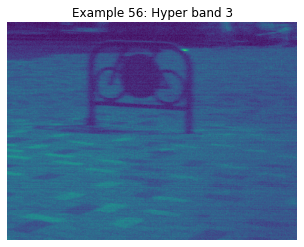

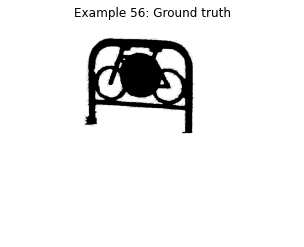

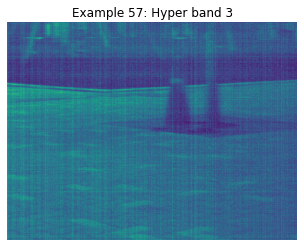

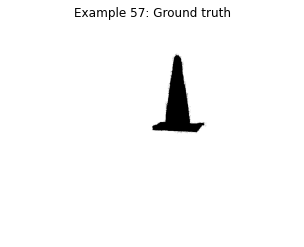

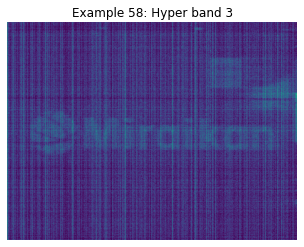

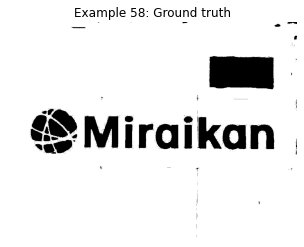

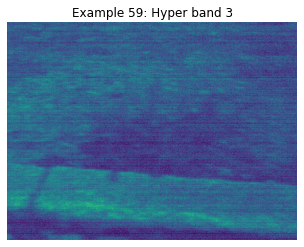

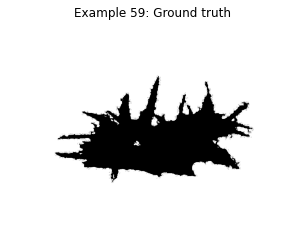

<Figure size 432x288 with 0 Axes>

In [8]:
if do_salient_objects:
    
    data_hsi, gt_hsi, data, gt = load_datasets(
        'SO', write=False)
    
    print('\nDataset info...')
    print('The shape of one original image:', data_hsi[0].shape)
    print('The shape of one original label:', gt_hsi[0].shape)
    print('The shape of one flattened image:', data[0].shape)
    print('The shape of one flattened label:', gt[0].shape)
    print('The number of different classes:', len(np.unique(gt[0])))
    
    for i in range(len(data_hsi)):
        
        # plot a sample band
        plt.imshow(data_hsi[i][:,:,3])
        plt.title(f'Example {i}: Hyper band 3')
        plt.axis("off")
        plt.show()
        plt.figure()
        # plot the labels
        plt.imshow(gt_hsi[i], cmap = 'Greys')
        plt.title(f'Example {i}: Ground truth')
        plt.axis("off")
        plt.show()
        plt.figure()
        print('\n')


In [9]:
if do_salient_objects:
    
    print(data_hsi[2][0:3, 0:3, 0:3])

[[[24.  8.  8.]
  [ 0. 16. 32.]
  [16.  8. 24.]]

 [[ 0. 16.  8.]
  [16. 16.  0.]
  [ 0. 16. 16.]]

 [[32.  0. 16.]
  [32. 16. 40.]
  [ 0.  8. 16.]]]


In [10]:
# baseline models

if do_salient_objects:

    # model with all bands included
    
    accs, bacs, f1s = [], [], []
    for i in range(0, len(data_hsi)):
        data = data_hsi[i].reshape(
                np.prod(data_hsi[i].shape[:2]), np.prod(data_hsi[i].shape[2:]))
        labels = gt_hsi[i].reshape(np.prod(data_hsi[i].shape[:2]))
    
        acc, bac, f1 = baseline_supervised_pass(data, labels, 'PF')
        accs.append(acc)
        bacs.append(bac)
        f1s.append(f1)
    
    print(f'Baseline model performance on raw data (ints) with all bands...')
    print(f'Validation Accuracy: {np.mean(accs)}')
    print(f'Validation Balanced Accuracy: {np.mean(bacs)}')
    print(f'Validation Macro Averaged F1 Score: {np.mean(f1s)}')
    
    # model with random bands
    
    accs, bacs, f1s = [], [], []
    for i in range(0, len(data_hsi)):
        data = data_hsi[i].reshape(
                np.prod(data_hsi[i].shape[:2]), np.prod(data_hsi[i].shape[2:]))
        labels = gt_hsi[i].reshape(np.prod(data_hsi[i].shape[:2]))
    
        acc, bac, f1 = baseline_supervised_pass(data, labels, 'PF', True, 10)
        accs.append(acc)
        bacs.append(bac)
        f1s.append(f1)
    
    print(f'\nBaseline model performance on raw data (ints) with {10} band random subset...')
    print(f'Validation Accuracy: {np.mean(accs)}')
    print(f'Validation Balanced Accuracy: {np.mean(bacs)}')
    print(f'Validation Macro Averaged F1 Score: {np.mean(f1s)}')

Baseline model performance on raw data (ints) with all bands...
Validation Accuracy: 0.9670092824142754
Validation Balanced Accuracy: 0.855723602414356
Validation Macro Averaged F1 Score: 0.8822920412025304

Baseline model performance on raw data (ints) with 10 band random subset...
Validation Accuracy: 0.9500172367510138
Validation Balanced Accuracy: 0.7781857116707714
Validation Macro Averaged F1 Score: 0.8049814342699293


## Indian pines dataset

The shape of the original imagery: (145, 145, 200)
The shape of the original labels: (145, 145) 

The shape of the flattened imagery: (10249, 200)
The shape of the flattened labels: (10249,)
The number of different classes: 16


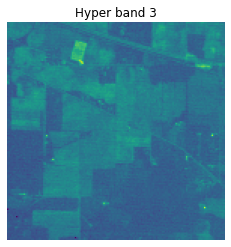

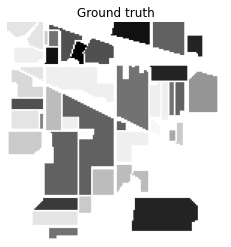

<Figure size 432x288 with 0 Axes>

In [11]:
if do_indian_pines:
    
    write = False
    data_hsi, gt_hsi, data, gt = load_datasets(
        'IN')
    
    print('The shape of the original imagery:', data_hsi.shape)
    print('The shape of the original labels:', gt_hsi.shape, '\n')
    print('The shape of the flattened imagery:', data.shape)
    print('The shape of the flattened labels:', gt.shape)
    print('The number of different classes:', len(np.unique(gt)))
    
    # plot a sample band
    plt.imshow(data_hsi[:,:,3]/np.max(data_hsi[:,:,3]*255))
    plt.title(f'Hyper band 3')
    plt.axis("off")
    plt.show()
    plt.figure()
    # plot the labels
    plt.imshow(gt_hsi, cmap='Greys')
    plt.title(f'Ground truth')
    plt.axis("off")
    plt.show()
    plt.figure()
    
    if write:
        np.save('../HyperSpectralRL/data/indian_pines/hyperspectral_imagery/indian_pines_corrected.npy', data)
        np.save('../HyperSpectralRL/data/indian_pines/gt_labels/indian_pines_gt.npy', gt.astype(np.uint8))
        

In [12]:
if do_indian_pines:
    
    print(data[0:3, 0:3])

[[ 65  93 104]
 [ 47  97 104]
 [ 80  97 102]]


In [13]:
# baseline models

if do_indian_pines:
    
    # model with all bands included
    
    acc, bac, f1 = baseline_supervised_pass(data, gt, 'IN')
    
    print(f'Baseline model performance on rescaled data (ints) with all bands...')
    print(f'Validation Accuracy: {acc}')
    print(f'Validation Balanced Accuracy: {bac}')
    print(f'Validation Macro Averaged F1 Score: {f1}')
    
    # model with random bands
    
    acc, bac, f1 = baseline_supervised_pass(data, gt, 'IN',  True, 10)
    
    print(f'\nBaseline model performance on rescaled data (ints) with {10} band random subset...')
    print(f'Validation Accuracy: {acc}')
    print(f'Validation Balanced Accuracy: {bac}')
    print(f'Validation Macro Averaged F1 Score: {f1}')

Baseline model performance on rescaled data (ints) with all bands...
Validation Accuracy: 0.26504065040650404
Validation Balanced Accuracy: 0.08574691943516832
Validation Macro Averaged F1 Score: 0.06477141245017229

Baseline model performance on rescaled data (ints) with 10 band random subset...
Validation Accuracy: 0.2523577235772358
Validation Balanced Accuracy: 0.07351473083917594
Validation Macro Averaged F1 Score: 0.042927407697502064


## Soil moisture dataset

In [14]:
if do_soil_moisture:
    
    write = False
    data_hsi, gt_hsi, data, gt = load_datasets(
        'SM')
    print('\nDataset info...')
    print('The shape of the original imagery:', data_hsi.shape)
    print('The shape of the original labels:', gt_hsi.shape)
    print('The shape of the flattened imagery:', data.shape)
    print('The shape of the flattened labels:', gt.shape)
    
    if write:
        np.save('../HyperSpectralRL/data/soil_moisture/hyperspectral_imagery/soil_moisture_hyper.npy', data)
        np.save('../HyperSpectralRL/data/soil_moisture/gt_labels/soil_moisture_gt.npy', gt)
        


Dataset info...
The shape of the original imagery: (679, 125)
The shape of the original labels: (679,)
The shape of the flattened imagery: (679, 125)
The shape of the flattened labels: (679,)


In [15]:
if do_soil_moisture:
    
    print(np.array(data_hsi)[0:3, 0:3])

[[0.08213071 0.05586301 0.05004707]
 [0.07951014 0.05532617 0.04911614]
 [0.08059854 0.05406527 0.04915002]]


In [16]:
# baseline models

if do_soil_moisture:
        
    # model with all bands included
    data = np.array(data_hsi)
    labels = np.array(gt_hsi)
    
    
    # model with all bands included
    print(f'Baseline model performance on raw data (floats) with all bands...')
    mse, r2 = baseline_supervised_pass(data, labels, 'SM')
    print(f'Validation MSE: {mse}')
    print(f'Validation r2: {r2}')
    
    # model with random bands
    print(f'\nBaseline model performance on raw data (floats) with {10} band random subset...')
    
    mse, r2 = baseline_supervised_pass(data, labels, 'SM', True, 10)
    print(f'Validation MSE: {mse}')
    print(f'Validation r2: {r2}')

Baseline model performance on raw data (floats) with all bands...
Validation MSE: 1.7420739818050397
Validation r2: 0.8765435718570657

Baseline model performance on raw data (floats) with 10 band random subset...
Validation MSE: 2.795629020661697
Validation r2: 0.8018807599973397
